Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               shuffle=True,
                                                               validation_split=0.2,
                                                               subset='training',
                                                               batch_size=batch_size)
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir_train, batch_size=batch_size, image_size=(img_height,
#     img_width), shuffle=True, seed=123, validation_split=0.2,subset='training'
# )
 

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                              seed=123,
                                                              image_size=(img_height, img_width),
                                                              shuffle=True,
                                                              validation_split=0.2,
                                                              subset='validation',
                                                              batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

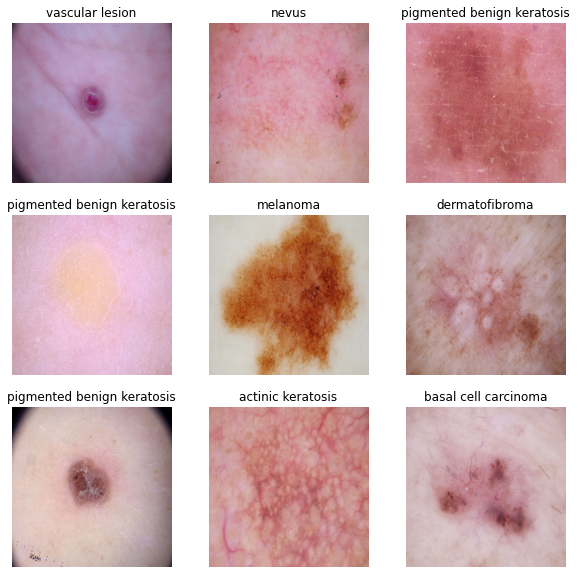

In [9]:
from matplotlib import figure
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax =plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

### Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

# There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the Image classification tutoria

In [11]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

Choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 161s 104ms/step - loss: 2.0544 - accuracy: 0.2093 - val_loss: 2.3646 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8531 - accuracy: 0.3125 - val_loss: 2.2155 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5912 - accuracy: 0.4503 - val_loss: 2.4695 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4144 - accuracy: 0.5011 - val_loss: 2.6293 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3142 - accuracy: 0.5430 - val_loss: 2.9740 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2575 - accuracy: 0.5597 - val_loss: 2.9071 - val_accuracy: 0.2174
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2309 - accuracy: 0.5558 - val_loss: 2.5453 - val_accuracy: 0.2609
Epoch 8/20
56/56 [===

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Visualizing training results

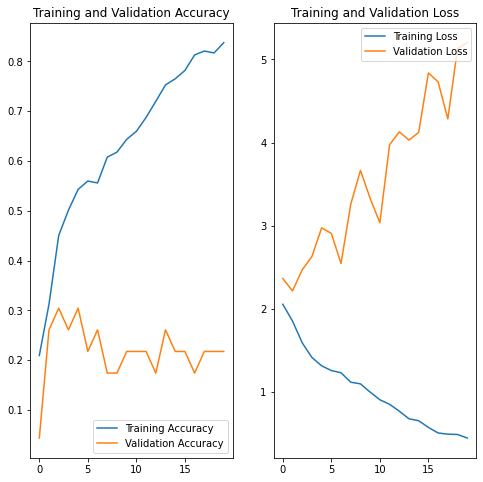

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

### model is overfitting

### Data augmentation
You can use the Keras preprocessing layers for data augmentation as well, such as tf.keras.layers.RandomFlip and tf.keras.layers.RandomRotation.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# as code is overfit train dataset accuracy getting more but validation is getting less
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.5),
  tf.keras.layers.RandomZoom(0.5),
])

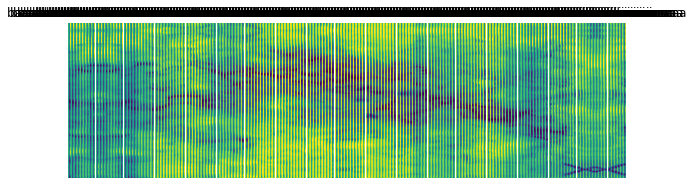

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
images, labels = next(iter(train_ds.take(1)))
j=9
label = labels[j]
realimage = images[j].numpy().astype("uint8")
dataaugmentedimage = tf.cast(tf.expand_dims(realimage, 0), tf.uint8)
plt.figure(figsize=(10, 10))
augmented_image = data_augmentation(realimage)

for i in range(len(augmented_image)):
    ax = plt.subplot(1, 180, i + 1)
    plt.imshow(augmented_image[i]) 
    # plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")
# plt.subplot(2,1,1)
# plt.imshow(realimage)
# plt.title(class_names[label])

Text(0.5, 1.0, 'basal cell carcinoma')

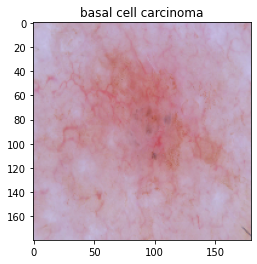

In [18]:
plt.imshow(realimage)
plt.title(class_names[label])

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

dropout_layer = tf.keras.Sequential([
  tf.keras.layers.Dropout(0.2)
])
## Your code goes here
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='valid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='valid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='valid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


### Compiling the model

In [20]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


54/56 [===========================>..] - ETA: 0s - loss: 2.0868 - accuracy: 0.2135

56/56 [==============================] - 3s 27ms/step - loss: 2.0834 - accuracy: 0.2148 - val_loss: 2.2512 - val_accuracy: 0.1304
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9299 - accuracy: 0.3041 - val_loss: 2.4045 - val_accuracy: 0.0435
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7618 - accuracy: 0.3566 - val_loss: 2.2416 - val_accuracy: 0.1739
Epoch 4/20
56/56 [==============================] - 1s 25ms/step - loss: 1.7259 - accuracy: 0.3817 - val_loss: 2.2286 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6936 - accuracy: 0.3956 - val_loss: 2.1713 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6276 - accuracy: 0.4001 - val_loss: 2.3755 - val_accuracy: 0.3478
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6324 - accuracy: 0.4174 - val_loss: 2.1357 - val_accuracy: 0.3043
Epoch 8/20
56/56 [======

### Visualizing the results

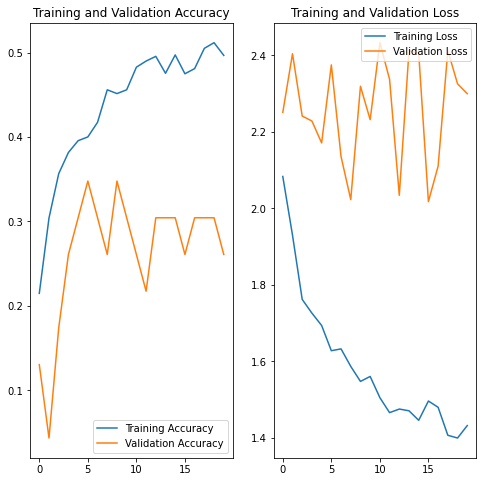

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

['actinic keratosis', 'seborrheic keratosis', 'pigmented benign keratosis', 'squamous cell carcinoma', 'vascular lesion', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus']
{'actinic keratosis': 114, 'seborrheic keratosis': 77, 'pigmented benign keratosis': 462, 'squamous cell carcinoma': 181, 'vascular lesion': 139, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357}
[114, 77, 462, 181, 139, 376, 95, 438, 357]


Text(0.5, 1.0, 'Classes balance')

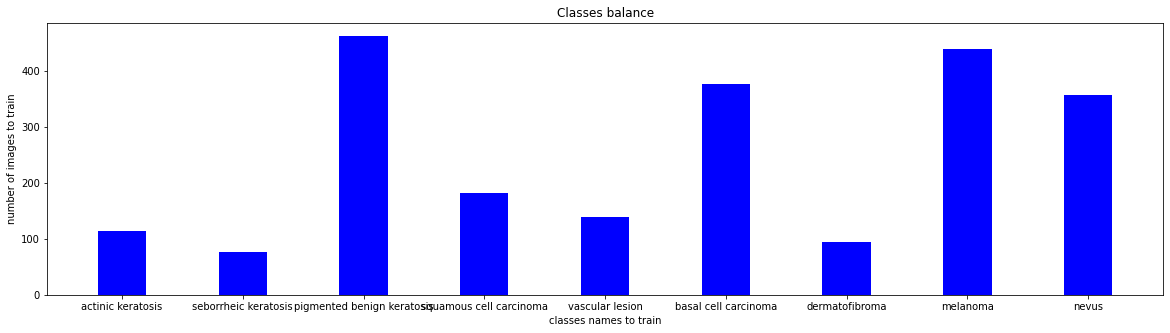

In [23]:
## Your code goes here.
def fileslength(filepath):
  data_d_dic ={}
  for x in filepath.iterdir():
    if x.is_dir():
      a=str(x)
      a=a.split("/")[-1]
      data_d_dic[a]=len(list(x.glob('*.jpg')))
  return data_d_dic

data_d_dictrain = fileslength(data_dir_train)
datalabels = list(data_d_dictrain.keys())
trainimages = list(data_d_dictrain.values())

print(datalabels)
print(data_d_dictrain)
print(trainimages)
fig = plt.figure(figsize =(20,5))
plt.bar(datalabels, trainimages, color = 'blue', width =0.4, label=trainimages)
plt.xlabel("classes names to train")
plt.ylabel("number of images to train")
plt.title("Classes balance")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### **seborrheic keratosis** has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### **pigmented benign keratosis** dominate the data in terms proportionate number of samples



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3DB5C58290>: 100%|██████████| 500/500 [00:23<00:00, 21.57 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3DB5C11FD0>: 100%|██████████| 500/500 [00:23<00:00, 21.42 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3DB5FCCD50>: 100%|██████████| 500/500 [00:18<00:00, 26.59 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3DB5FB5C50>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3DB5CD7F50>: 100%|██████████| 500/500 [01:36<00:00,  5.17 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3DB50C5D10>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F3DB5BC3690>: 100%|██████████| 500/500 [00:42<00:00, 11.76 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3DB8F078D0>: 100%|██████████| 500/500 [00:18<00:00, 27.49 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_Cancer_images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3DB5C9A790>: 100%|██████████| 500/500 [00:17<00:00, 27.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
# path_list = [x for x in glob(pathlib.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list = list(data_dir_train.glob('*/*.jpg'))
path_list_new = list(data_dir_train.glob('*/output/*.jpg'))

In [28]:
lesion_list_new = [str(y).split('/')[-3] for y in list(data_dir_train.glob('*/output/*.jpg'))]
lesion_list = [str(y).split('/')[-2] for y in list(data_dir_train.glob('*/*.jpg'))]

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict = dict(zip(path_list, lesion_list_new))

In [30]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [31]:
new_df['Label'].value_counts()

actinic keratosis             1000
seborrheic keratosis          1000
pigmented benign keratosis    1000
squamous cell carcinoma       1000
vascular lesion                739
basal cell carcinoma           500
dermatofibroma                 500
melanoma                       500
nevus                          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
## your code goes here
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(padding='valid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(padding='valid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(padding='valid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [44]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# your model fit code

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


168/169 [============================>.] - ETA: 0s - loss: 2.1452 - accuracy: 0.3146

169/169 [==============================] - 30s 38ms/step - loss: 2.1430 - accuracy: 0.3149 - val_loss: 3.2847 - val_accuracy: 0.1304
Epoch 2/30
169/169 [==============================] - 5s 30ms/step - loss: 1.7298 - accuracy: 0.3904 - val_loss: 2.2183 - val_accuracy: 0.2174
Epoch 3/30
169/169 [==============================] - 5s 30ms/step - loss: 1.6109 - accuracy: 0.4126 - val_loss: 2.2505 - val_accuracy: 0.0870
Epoch 4/30
169/169 [==============================] - 5s 30ms/step - loss: 1.4977 - accuracy: 0.4358 - val_loss: 2.4889 - val_accuracy: 0.2174
Epoch 5/30
169/169 [==============================] - 5s 30ms/step - loss: 1.5016 - accuracy: 0.4418 - val_loss: 2.1969 - val_accuracy: 0.3043
Epoch 6/30
169/169 [==============================] - 5s 30ms/step - loss: 1.4569 - accuracy: 0.4484 - val_loss: 2.0313 - val_accuracy: 0.1739
Epoch 7/30
169/169 [==============================] - 5s 30ms/step - loss: 1.3860 - accuracy: 0.4687 - val_loss: 1.7889 - val_accuracy: 0.3043
Epoch 8/3

#### **Todo:**  Visualize the model results

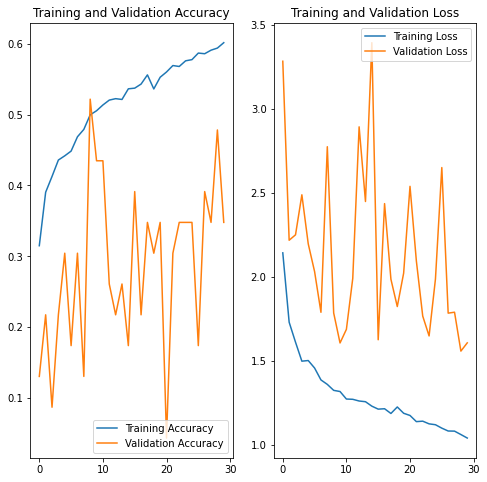

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
#yes we get rid of overfitting and class rebalance.